## 1. Cargar librerías y datos

In [1]:
pip install keras_tuner


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: /Users/sporella/Desktop/magister/topicos_ciencia_datos/proyecto1/env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Dropout, Embedding, Flatten, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras_tuner
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc,
    classification_report
)

print("✓ Librerías cargadas")

✓ Librerías cargadas


/Users/sporella/Desktop/magister/topicos_ciencia_datos/proyecto1/env/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 2. Cargar dataset procesado

Usamos el dataset ya codificado del notebook `preprocesamiento.ipynb`.

In [3]:
# Cargar dataset ya procesado
encoded_df = pd.read_csv('dataset/dataset_elpino_codes_encoded.csv')

print(f"Dataset cargado: {encoded_df.shape}")
encoded_df.head()

Dataset cargado: (14561, 86)


,Diag 01 Principal (cod+des),Diag 02 Secundario (cod+des),Diag 03 Secundario (cod+des),Diag 04 Secundario (cod+des),Diag 05 Secundario (cod+des),Diag 06 Secundario (cod+des),Diag 07 Secundario (cod+des),Diag 08 Secundario (cod+des),Diag 09 Secundario (cod+des),Diag 10 Secundario (cod+des),...,Sección,Capítulo,IR-GRD CÓDIGO,NOMBRE DEL GRUPO GRD,Peso v31,CDM_COD,CATEGORÍA DIAGNÓSTICA MAYOR CDM,TIPO_COD,TIPO GRD,Precio FONASA 2016
0,935,997,1827,2626,1028,2422,2366,1029,934,2082,...,A30-A49 OTRAS ENFERMEDADES BACTERIANAS,Cap.01 CIERTAS ENFERMEDADES INFECCIOSAS Y PAR...,184103,MH SEPTICEMIA W/MCC,1.4032,18,ENFERMEDADES INFECCIOSAS Y PARASITARIAS SISTÉM...,MH,MÉDICO HOSPITALIZADO,2.104800e+06
1,3827,2008,3298,3297,3364,4272,4245,2095,2090,2085,...,U00-U49 ASIGNACION PROVISIONAL DE NUEVAS ENFE...,Cap.22 CÓDIGOS PARA SITUACIONES ESPECIALES (U...,41013,PH VENTILACIÓN MECÁNICA PROLONGADA CON TRAQUEO...,11.7045,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,1.893578e+07
2,2223,3374,3373,2073,4243,2012,3833,1025,1034,993,...,K55-K64 OTRAS ENFERMEDADES DE LOS INTESTINOS,Cap.11 ENFERMEDADES DEL APARATO DIGESTIVO (K0...,41013,PH VENTILACIÓN MECÁNICA PROLONGADA CON TRAQUEO...,11.7045,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,1.893578e+07
3,2295,2267,2651,1249,1404,1401,2074,2645,2063,3343,...,K70-K77 ENFERMEDADES DE HÍGADO,Cap.11 ENFERMEDADES DEL APARATO DIGESTIVO (K0...,41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,5.8207,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,9.416848e+06
4,3789,4226,3506,3534,3975,2097,2012,3833,3827,2687,...,T80-T88 COMPLICACIONES DE LA ATENCIÓN QUIRÚRG...,"Cap.19 LESIONES TRAUMÁTICAS, ENVENENAMIENTOS ...",41023,PH VENTILACIÓN MECÁNICA PROLONGADA SIN TRAQUEO...,5.8207,4,ENFERMEDADES Y TRASTORNOS DEL APARATO RESPIRAT...,PH,PROCEDIMIENTO HOSPITALIZADO,9.416848e+06


## 3. Filtrar por categoría de interés

Filtramos por diagnósticos que empiecen con 'J' (enfermedades respiratorias).

In [4]:
# Filtrar por código CIE-10 que empiece con 'K'
encoded_df_filter = encoded_df.loc[encoded_df["Código"].str.startswith('J', na=False)]

# Contar registros por GRD_final
grd_cuenta = encoded_df_filter.groupby("GRD_final").size().sort_values(ascending=False).reset_index(name='Cuenta')

print("\nTop 10 GRD con más casos:")
print(grd_cuenta.head(10))

# Filtrar GRD con al menos 5 casos
grd_con_datos = grd_cuenta.GRD_final[grd_cuenta.Cuenta >= 5]
encoded_df_filter_final = encoded_df_filter[encoded_df_filter.GRD_final.isin(grd_con_datos)].copy()

print(f"\nRegistros después de filtrar: {len(encoded_df_filter_final)}")
print(f"GRD únicos: {encoded_df_filter_final['GRD_final'].nunique()}")


Top 10 GRD con más casos:
   GRD_final  Cuenta
0       4416     318
1       4418     209
2       4421     174
3       4417     149
4       4411      94
5       4415      53
6       3413      49
7       4102      41
8       4120      30
9       4420      30

Registros después de filtrar: 1182
GRD únicos: 12


## 4. Visualizar distribución de clases

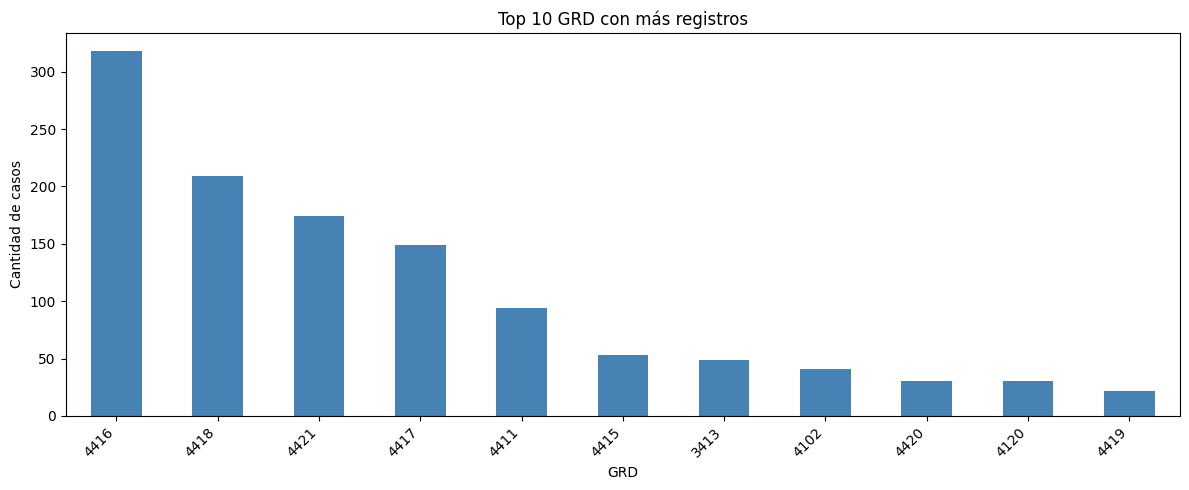


Total de clases: 11


In [5]:
# Visualizar top 10 GRD
top_grds = encoded_df_filter_final['GRD_final'].value_counts().head(11)

plt.figure(figsize=(12, 5))
top_grds.plot(kind='bar', color='steelblue')
plt.title('Top 10 GRD con más registros')
plt.xlabel('GRD')
plt.ylabel('Cantidad de casos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal de clases: {len(top_grds)}")

## 5. Preparar features (X) y target (Y)

Usamos las columnas codificadas de diagnósticos y procedimientos como features.

In [6]:
# Identificar columnas de features
diag_cols = [c for c in encoded_df_filter_final.columns if c.startswith('Diag')]
proc_cols = [c for c in encoded_df_filter_final.columns if c.startswith('Proced')]

# Usar diagnóstico principal + primeros 5 procedimientos + edad + sexo
#feature_cols = proc_cols[:5] + ['Edad', 'Sexo']
feature_cols = diag_cols[:1] + proc_cols[:5] + ['Edad', 'Sexo']

print(f"Features seleccionadas ({len(feature_cols)}):")
print(feature_cols)

# Crear matriz X
X = encoded_df_filter_final[feature_cols].fillna(0).to_numpy()

print(f"\nX shape: {X.shape}")
print(f"Primeros 3 registros:")
print(X[:3])

Features seleccionadas (8):
['Diag 01 Principal (cod+des)', 'Proced 01 Principal (cod+des)', 'Proced 02 Secundario (cod+des)', 'Proced 03 Secundario (cod+des)', 'Proced 04 Secundario (cod+des)', 'Proced 05 Secundario (cod+des)', 'Edad', 'Sexo']

X shape: (1182, 8)
Primeros 3 registros:
[[2076  617  646  620  633  687   56    0]
 [2014  837  812  784  609  617   19    1]
 [2097   51  837  812  617  609   67    1]]


### 5.1 Separar features categóricas y numéricas

Para usar embeddings, necesitamos separar:
- **Categóricas**: Diag y Proced (códigos enteros que representan categorías)
- **Numéricas**: Edad y Sexo

In [7]:
# Separar features categóricas (para embedding) y numéricas
cat_feature_cols = diag_cols[:1] + proc_cols[:5]  # Diag principal + 5 procedimientos
num_feature_cols = ['Edad', 'Sexo']

print(f"Features categóricas ({len(cat_feature_cols)}):")
for col in cat_feature_cols:
    print(f"  - {col}")

print(f"\nFeatures numéricas ({len(num_feature_cols)}):")
for col in num_feature_cols:
    print(f"  - {col}")

# Crear arrays separados
X_cat = encoded_df_filter_final[cat_feature_cols].fillna(0).astype(int).to_numpy()
X_num = encoded_df_filter_final[num_feature_cols].fillna(0).to_numpy()

# Calcular vocabularios (número de categorías únicas + 1 para padding)
vocab_sizes = []
for col in cat_feature_cols:
    vocab_size = int(encoded_df_filter_final[col].max()) + 1
    vocab_sizes.append(vocab_size)
    print(f"\n{col}: {vocab_size} categorías únicas")

print(f"\nX_cat shape: {X_cat.shape}")
print(f"X_num shape: {X_num.shape}")
print(f"\nPrimeros 3 registros (categóricas):")
print(X_cat[:3])
print(f"\nPrimeros 3 registros (numéricas):")
print(X_num[:3])

Features categóricas (6):
  - Diag 01 Principal (cod+des)
  - Proced 01 Principal (cod+des)
  - Proced 02 Secundario (cod+des)
  - Proced 03 Secundario (cod+des)
  - Proced 04 Secundario (cod+des)
  - Proced 05 Secundario (cod+des)

Features numéricas (2):
  - Edad
  - Sexo

Diag 01 Principal (cod+des): 2109 categorías únicas

Proced 01 Principal (cod+des): 880 categorías únicas

Proced 02 Secundario (cod+des): 901 categorías únicas

Proced 03 Secundario (cod+des): 901 categorías únicas

Proced 04 Secundario (cod+des): 901 categorías únicas

Proced 05 Secundario (cod+des): 901 categorías únicas

X_cat shape: (1182, 6)
X_num shape: (1182, 2)

Primeros 3 registros (categóricas):
[[2076  617  646  620  633  687]
 [2014  837  812  784  609  617]
 [2097   51  837  812  617  609]]

Primeros 3 registros (numéricas):
[[56  0]
 [19  1]
 [67  1]]


## 6. Codificar target (Y) - Enfoque One-Hot

Similar al ejemplo de clase con clasificación multiclase.

In [8]:
# Codificar GRD_final como categorías numéricas
Q = encoded_df_filter_final['GRD_final'].astype('category').cat.codes

print("Distribución de clases:")
print(Q.value_counts().sort_index())

# One-Hot encoding para Keras (clasificación multiclase)
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Q.to_numpy().reshape(-1, 1))

print(f"\nY shape: {Y.shape}")
print(f"Número de clases: {Y.shape[1]}")
print(f"\nPrimeros 3 registros (one-hot):")
print(Y[:3])

Distribución de clases:
0      49
1      13
2      41
3      30
4      94
5      53
6     318
7     149
8     209
9      22
10     30
11    174
Name: count, dtype: int64

Y shape: (1182, 12)
Número de clases: 12

Primeros 3 registros (one-hot):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 7. Mapeo de códigos a nombres de GRD

In [9]:
# Crear mapeo de índice numérico a código GRD
label_encoder = LabelEncoder()
label_encoder.fit(encoded_df_filter_final['GRD_final'])

grd_labels = label_encoder.classes_

print(f"Mapeo de clases (primeras 10):")
for idx, grd in enumerate(grd_labels[:10]):
    print(f"  {idx} -> {grd}")

Mapeo de clases (primeras 10):
  0 -> 3413
  1 -> 4101
  2 -> 4102
  3 -> 4120
  4 -> 4411
  5 -> 4415
  6 -> 4416
  7 -> 4417
  8 -> 4418
  9 -> 4419


## 8. Split train/test con estratificación

In [10]:
# Split 80/20 con estratificación para ambos tipos de features
x_cat_train, x_cat_test, x_num_train, x_num_test, y_train, y_test = train_test_split(
    X_cat, X_num, Y,
    test_size=0.2,
    stratify=Y,  # Mantener proporción de clases
    random_state=42
)

print(f"Train set (cat): {x_cat_train.shape}")
print(f"Train set (num): {x_num_train.shape}")
print(f"Test set (cat): {x_cat_test.shape}")
print(f"Test set (num): {x_num_test.shape}")

Train set (cat): (945, 6)
Train set (num): (945, 2)
Test set (cat): (237, 6)
Test set (num): (237, 2)


## 9. Visualizar desbalanceo de clases

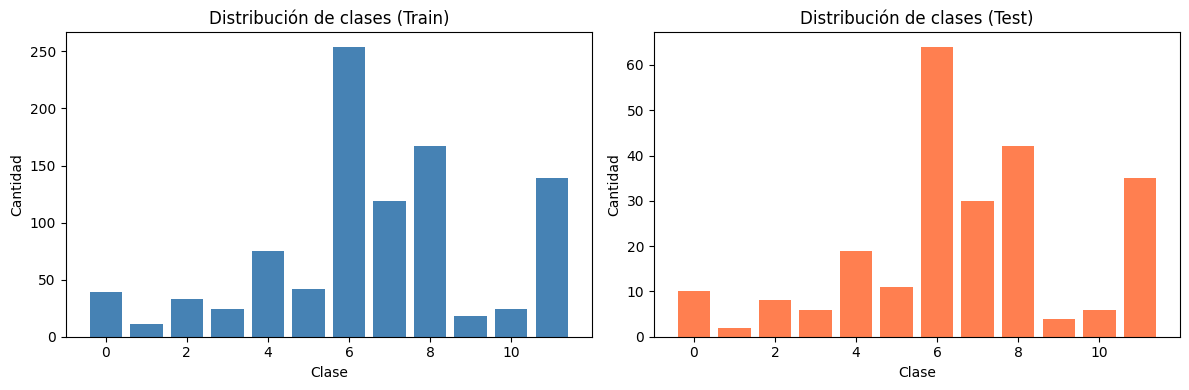


Clases con menos de 10 registros en train: 0


In [11]:
# Contar clases en train y test
train_classes = np.argmax(y_train, axis=1)
test_classes = np.argmax(y_test, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train
class_counts_train = pd.Series(train_classes).value_counts().sort_index()
axes[0].bar(class_counts_train.index, class_counts_train.values, color='steelblue')
axes[0].set_title('Distribución de clases (Train)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

# Test
class_counts_test = pd.Series(test_classes).value_counts().sort_index()
axes[1].bar(class_counts_test.index, class_counts_test.values, color='coral')
axes[1].set_title('Distribución de clases (Test)')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

print(f"\nClases con menos de 10 registros en train: {(class_counts_train < 10).sum()}")

## 10. Balanceo de clases: comparación de técnicas

Comparamos tres enfoques:
1. **RandomOverSampler (ROS)**: Duplica muestras de clases minoritarias
2. **RandomUnderSampler (RUS)**: Reduce muestras de clases mayoritarias
3. **Sin balanceo**: Datos originales

Train original:    (945, 8)
Train ROS:         (3048, 8)
Train RUS:         (132, 8)


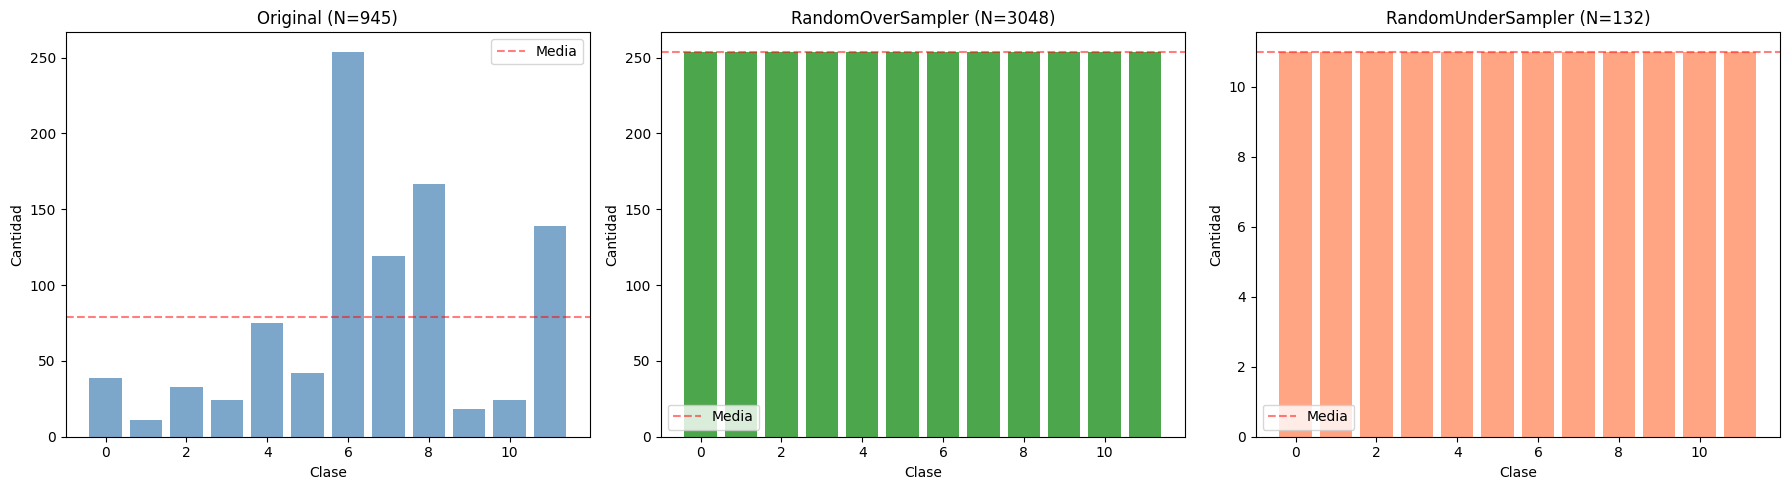


📊 Análisis de balanceo:
  Original - Std: 75.72, Min: 11, Max: 254
  ROS      - Std: 0.00, Min: 254, Max: 254
  RUS      - Std: 0.00, Min: 11, Max: 11


In [12]:
# Concatenar features categóricas y numéricas para balanceo
x_train_combined = np.concatenate([x_cat_train, x_num_train], axis=1)
x_test_combined = np.concatenate([x_cat_test, x_num_test], axis=1)

# Aplicar RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_ros_combined, y_train_ros = ros.fit_resample(x_train_combined, y_train)

# Aplicar RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
x_train_rus_combined, y_train_rus = rus.fit_resample(x_train_combined, y_train)

# Separar nuevamente después del balanceo
n_cat = x_cat_train.shape[1]
x_cat_train_ros = x_train_ros_combined[:, :n_cat]
x_num_train_ros = x_train_ros_combined[:, n_cat:]

x_cat_train_rus = x_train_rus_combined[:, :n_cat]
x_num_train_rus = x_train_rus_combined[:, n_cat:]

print(f"Train original:    {x_train_combined.shape}")
print(f"Train ROS:         {x_train_ros_combined.shape}")
print(f"Train RUS:         {x_train_rus_combined.shape}")

# Visualizar después del balanceo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original
train_classes = np.argmax(y_train, axis=1)
class_counts_original = pd.Series(train_classes).value_counts().sort_index()
axes[0].bar(class_counts_original.index, class_counts_original.values, color='steelblue', alpha=0.7)
axes[0].set_title(f'Original (N={len(train_classes)})')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')
axes[0].axhline(y=class_counts_original.mean(), color='r', linestyle='--', alpha=0.5, label='Media')
axes[0].legend()

# RandomOverSampler
train_ros_classes = np.argmax(y_train_ros, axis=1)
class_counts_ros = pd.Series(train_ros_classes).value_counts().sort_index()
axes[1].bar(class_counts_ros.index, class_counts_ros.values, color='green', alpha=0.7)
axes[1].set_title(f'RandomOverSampler (N={len(train_ros_classes)})')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')
axes[1].axhline(y=class_counts_ros.mean(), color='r', linestyle='--', alpha=0.5, label='Media')
axes[1].legend()

# RandomUnderSampler
train_rus_classes = np.argmax(y_train_rus, axis=1)
class_counts_rus = pd.Series(train_rus_classes).value_counts().sort_index()
axes[2].bar(class_counts_rus.index, class_counts_rus.values, color='coral', alpha=0.7)
axes[2].set_title(f'RandomUnderSampler (N={len(train_rus_classes)})')
axes[2].set_xlabel('Clase')
axes[2].set_ylabel('Cantidad')
axes[2].axhline(y=class_counts_rus.mean(), color='r', linestyle='--', alpha=0.5, label='Media')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Análisis de balanceo:")
print(f"  Original - Std: {class_counts_original.std():.2f}, Min: {class_counts_original.min()}, Max: {class_counts_original.max()}")
print(f"  ROS      - Std: {class_counts_ros.std():.2f}, Min: {class_counts_ros.min()}, Max: {class_counts_ros.max()}")
print(f"  RUS      - Std: {class_counts_rus.std():.2f}, Min: {class_counts_rus.min()}, Max: {class_counts_rus.max()}")

### 10.1 Selección de estrategia de balanceo

**Trade-offs:**
- **ROS**: Aumenta tamaño del dataset, puede causar overfitting (duplica ejemplos)
- **RUS**: Reduce tamaño del dataset, pierde información pero evita overfitting
- **Sin balanceo**: Mantiene distribución real pero puede sesgar hacia clases mayoritarias

Para este análisis usaremos **RandomOverSampler (ROS)** para mantener toda la información disponible.

## 11. Definir función para crear modelo con Keras Tuner

Siguiendo el patrón de la clase, creamos una función que Keras Tuner pueda optimizar.

In [13]:
def build_model(hp):
    """
    Función para crear modelo con embeddings para features categóricas.

    Arquitectura:
    - Embeddings para cada feature categórica (Diag + Proced)
    - Concatenación con features numéricas
    - Capas densas con dropout
    - Softmax para clasificación multiclase

    Hiperparámetros a optimizar:
    - Dimensión de embedding: 8, 16, 32
    - Número de capas ocultas: 1, 2 o 3
    - Neuronas por capa: 64, 128, 256, 512
    - Dropout: 0.2, 0.3, 0.4
    - Learning rate: 0.001, 0.0001
    """

    # Dimensión de embedding (mismo para todas las features categóricas)
    embedding_dim = hp.Choice("embedding_dim", [8, 16, 32])

    # Inputs: una entrada por cada feature categórica + una para numéricas
    cat_inputs = []
    embeddings = []

    # Crear embedding para cada feature categórica
    for i, vocab_size in enumerate(vocab_sizes):
        input_cat = Input(shape=(1,), name=f'cat_input_{i}')
        cat_inputs.append(input_cat)

        # Embedding layer
        emb = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name=f'embedding_{i}'
        )(input_cat)
        emb = Flatten()(emb)
        embeddings.append(emb)

    # Input para features numéricas
    num_input = Input(shape=(x_num_train_ros.shape[1],), name='num_input')

    # Concatenar todos los embeddings + features numéricas
    if embeddings:
        concat = Concatenate()(embeddings + [num_input])
    else:
        concat = num_input

    # Capas densas
    x = concat
    for i in range(hp.Choice("num_capas", [1, 2, 3])):
        x = Dense(
            hp.Choice(f"neuronas_capa_{i}", [64, 128, 256, 512]),
            activation='relu',
            name=f'dense_{i}'
        )(x)
        x = Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4]))(x)

    # Capa de salida
    output = Dense(Y.shape[1], activation='softmax', name='output')(x)

    # Crear modelo
    model = Model(inputs=cat_inputs + [num_input], outputs=output)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
    )

    return model

print("✓ Función build_model con embeddings definida")

✓ Función build_model con embeddings definida


## 12. Configurar Keras Tuner (RandomSearch)

In [14]:
# Configurar tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_acc", direction="max"),
    max_trials=20,  # Número de combinaciones a probar
    executions_per_trial=2,  # Entrenar cada config 2 veces
    overwrite=True,
    directory="modelos_keras",
    project_name="grd_clasificacion"
)

print("✓ Keras Tuner configurado")
tuner.search_space_summary()

✓ Keras Tuner configurado
Search space summary
Default search space size: 5
embedding_dim (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
num_capas (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
neuronas_capa_0 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
lr (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


## 13. Ejecutar búsqueda de hiperparámetros

**Nota:** Esto puede tomar varios minutos dependiendo de `max_trials`. (14 min aprox con la configuración actual)

In [15]:
# Buscar mejores hiperparámetros usando datos balanceados con ROS
# Preparar inputs para el modelo: lista de arrays, uno por cada feature categórica + numéricas
x_train_inputs = [x_cat_train_ros[:, i:i+1] for i in range(x_cat_train_ros.shape[1])] + [x_num_train_ros]
x_test_inputs = [x_cat_test[:, i:i+1] for i in range(x_cat_test.shape[1])] + [x_num_test]

# Callback simple para mostrar progreso cada epoch
class SimpleProgressCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_count = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if logs:
            print(f"Epoch {epoch+1}/15 - loss: {logs.get('loss', 0):.4f} - acc: {logs.get('acc', 0):.4f} - val_loss: {logs.get('val_loss', 0):.4f} - val_acc: {logs.get('val_acc', 0):.4f}")

# Buscar con callback simple
tuner.search(
    x_train_inputs,
    y_train_ros,
    validation_data=(x_test_inputs, y_test),
    epochs=15,
    batch_size=32,
    verbose=0,
    callbacks=[SimpleProgressCallback()]
)

print(f"\n✓ Búsqueda completada - Total trials: {len(tuner.oracle.trials)}")

Epoch 1/15 - loss: 7.3841 - acc: 0.0932 - val_loss: 2.7716 - val_acc: 0.1224
Epoch 2/15 - loss: 5.2013 - acc: 0.0978 - val_loss: 2.7778 - val_acc: 0.1350
Epoch 3/15 - loss: 3.9800 - acc: 0.1211 - val_loss: 2.5267 - val_acc: 0.1646
Epoch 4/15 - loss: 3.2765 - acc: 0.1237 - val_loss: 2.4632 - val_acc: 0.1814
Epoch 5/15 - loss: 2.9071 - acc: 0.1329 - val_loss: 2.4487 - val_acc: 0.1983
Epoch 6/15 - loss: 2.7235 - acc: 0.1335 - val_loss: 2.4250 - val_acc: 0.1983
Epoch 7/15 - loss: 2.6141 - acc: 0.1273 - val_loss: 2.3916 - val_acc: 0.1899
Epoch 8/15 - loss: 2.5625 - acc: 0.1440 - val_loss: 2.3469 - val_acc: 0.1772
Epoch 9/15 - loss: 2.5183 - acc: 0.1175 - val_loss: 2.2919 - val_acc: 0.1983
Epoch 10/15 - loss: 2.4640 - acc: 0.1237 - val_loss: 2.2262 - val_acc: 0.2068
Epoch 11/15 - loss: 2.4091 - acc: 0.1312 - val_loss: 2.1639 - val_acc: 0.2025
Epoch 12/15 - loss: 2.3845 - acc: 0.1332 - val_loss: 2.1088 - val_acc: 0.2110
Epoch 13/15 - loss: 2.3581 - acc: 0.1411 - val_loss: 2.0489 - val_acc: 0.

## 14. Obtener mejor modelo

In [16]:
# Obtener mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejores hiperparámetros:")
print(f"  Dimensión embedding: {best_hps.get('embedding_dim')}")
print(f"  Número de capas: {best_hps.get('num_capas')}")
print(f"  Dropout: {best_hps.get('dropout')}")
print(f"  Learning rate: {best_hps.get('lr')}")
for i in range(best_hps.get('num_capas')):
    print(f"  Neuronas capa {i}: {best_hps.get(f'neuronas_capa_{i}')}")

# Obtener mejor modelo
mejor_modelo = tuner.get_best_models(num_models=1)[0]
mejor_modelo.summary()

Mejores hiperparámetros:
  Dimensión embedding: 32
  Número de capas: 2
  Dropout: 0.4
  Learning rate: 0.001
  Neuronas capa 0: 64
  Neuronas capa 1: 512
Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cat_input_0 (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_input_1 (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cat_input_2 (InputLayer)      │ (None, 1)                 │ 

/Users/sporella/Desktop/magister/topicos_ciencia_datos/proyecto1/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 15. Guardar mejor modelo

In [17]:
# Guardar modelo
import os

if not os.path.exists("models"):
    os.makedirs("models")

mejor_modelo.save('models/mejor_modelo_grd.keras')
print("✓ Modelo guardado en: models/mejor_modelo_grd.keras")

✓ Modelo guardado en: models/mejor_modelo_grd.keras


## 16. Evaluar en conjunto de test

In [18]:
# Predecir probabilidades con inputs correctos
y_pred_probs = mejor_modelo.predict(x_test_inputs)

# Convertir probabilidades a clases
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular métricas
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Métricas en conjunto de test:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {precision:.4f} (macro)")
print(f"  Recall:    {recall:.4f} (macro)")
print(f"  F1-Score:  {f1:.4f} (macro)")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Métricas en conjunto de test:
  Accuracy:  0.9916
  Precision: 0.9975 (macro)
  Recall:    0.9722 (macro)
  F1-Score:  0.9821 (macro)


## 17. Matriz de Confusión

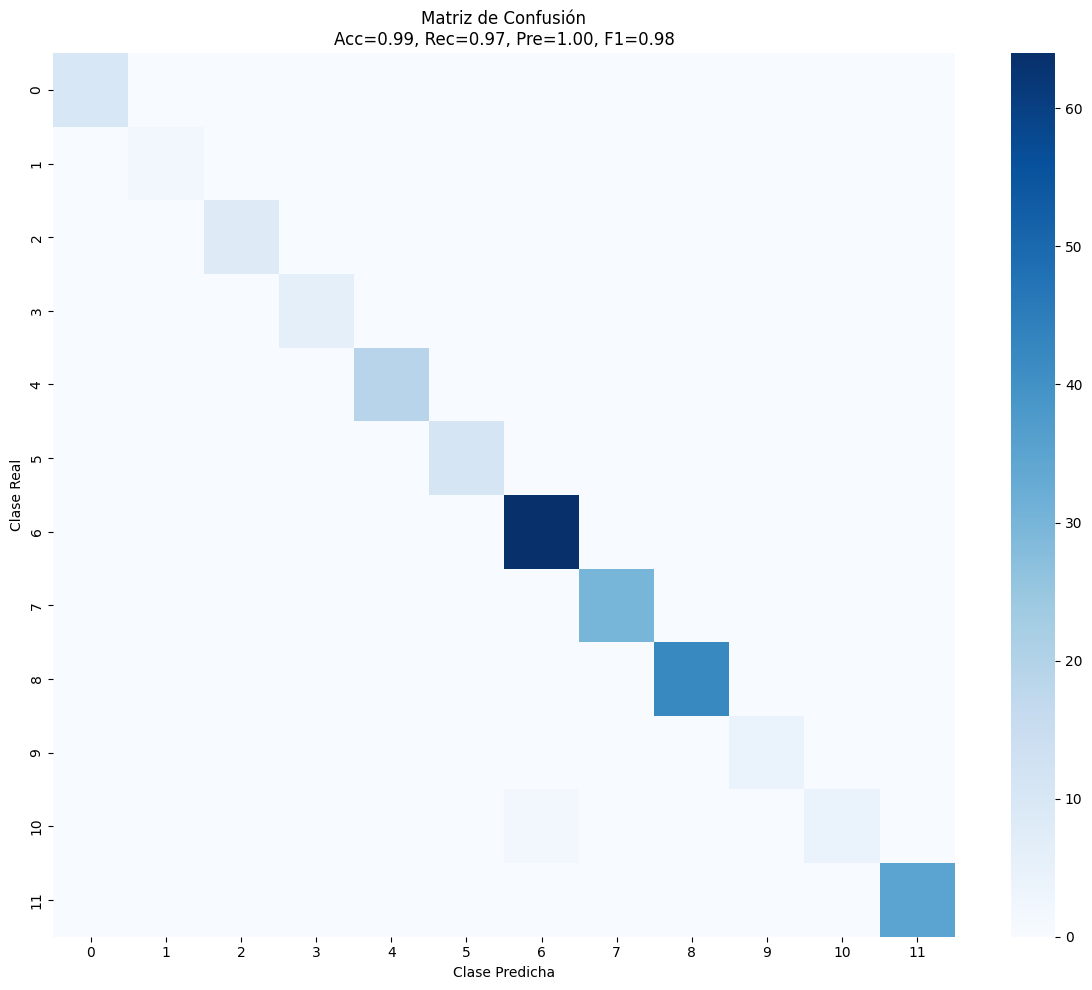

Matriz shape: (12, 12)


In [19]:
# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar (puede ser grande si hay muchas clases)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True, fmt='d')
plt.title(f'Matriz de Confusión\nAcc={acc:.2f}, Rec={recall:.2f}, Pre={precision:.2f}, F1={f1:.2f}')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.tight_layout()
plt.savefig('models/confusion_matrix_grd.png', dpi=150)
plt.show()

print(f"Matriz shape: {cm.shape}")

## 18. Reporte de clasificación por clase

In [20]:
# Reporte detallado por clase
report = classification_report(
    y_true,
    y_pred,
    target_names=[str(g) for g in grd_labels],
    zero_division=0
)

print("Reporte de clasificación por GRD:")
print(report)

Reporte de clasificación por GRD:
              precision    recall  f1-score   support

        3413       1.00      1.00      1.00        10
        4101       1.00      1.00      1.00         2
        4102       1.00      1.00      1.00         8
        4120       1.00      1.00      1.00         6
        4411       1.00      1.00      1.00        19
        4415       1.00      1.00      1.00        11
        4416       0.97      1.00      0.98        64
        4417       1.00      1.00      1.00        30
        4418       1.00      1.00      1.00        42
        4419       1.00      1.00      1.00         4
        4420       1.00      0.67      0.80         6
        4421       1.00      1.00      1.00        35

    accuracy                           0.99       237
   macro avg       1.00      0.97      0.98       237
weighted avg       0.99      0.99      0.99       237



## 19. Curvas ROC (One-vs-Rest)

Visualizamos curvas ROC para las clases principales.

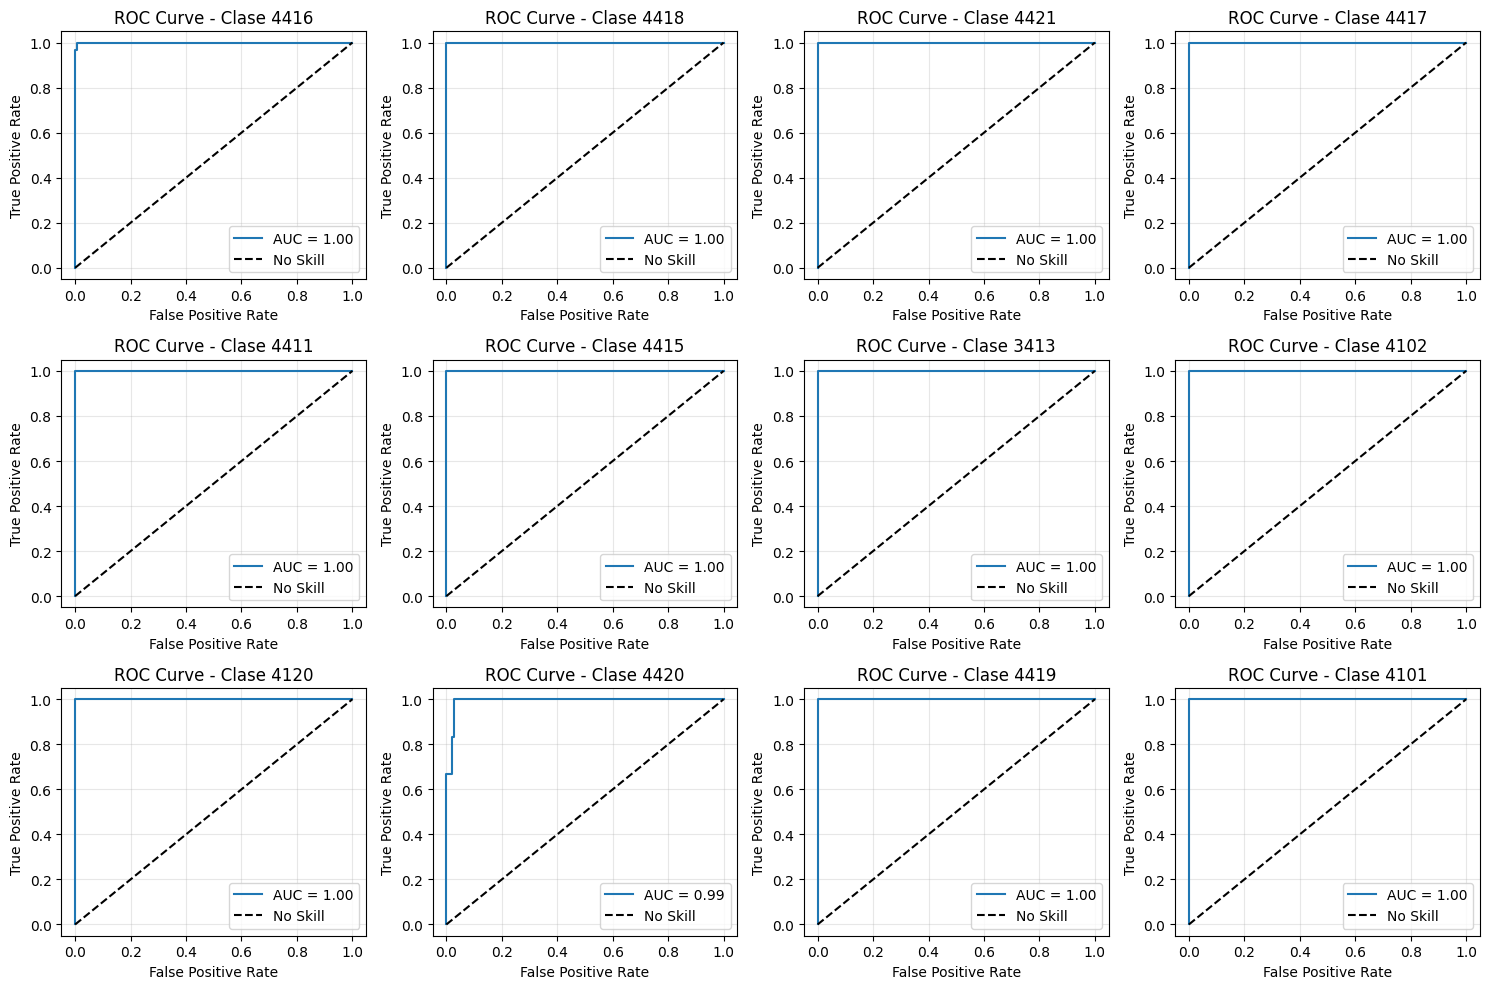

In [21]:
# Seleccionar top 12 clases más frecuentes para visualizar ROC
top_classes = pd.Series(y_true).value_counts().head(12).index.tolist()

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for idx, cls in enumerate(top_classes):
    # ROC para esta clase (one-vs-rest)
    fpr, tpr, _ = roc_curve(y_test[:, cls], y_pred_probs[:, cls])
    roc_auc = auc(fpr, tpr)

    axes[idx].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[idx].plot([0, 1], [0, 1], 'k--', label='No Skill')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'ROC Curve - Clase {grd_labels[cls]}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/roc_curves_grd.png', dpi=150)
plt.show()

## 20. Análisis de errores - Top confusiones


Top 15 confusiones más frecuentes:
 Real  Predicho  Count
 4420      4416      2


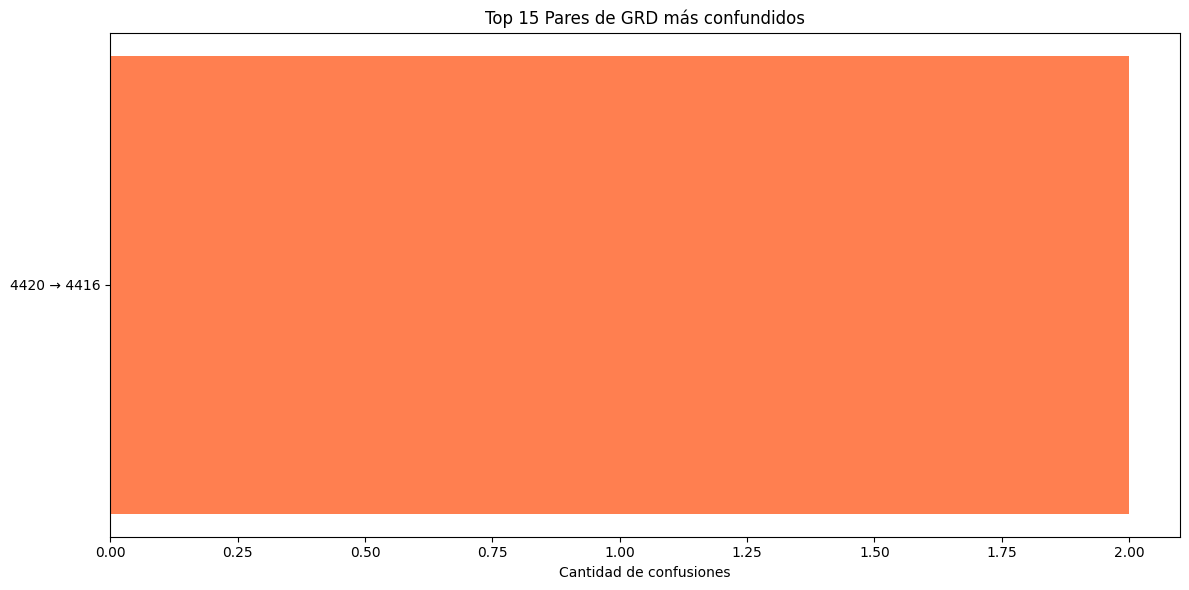

In [22]:
# Encontrar top confusiones (fuera de diagonal)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)  # Eliminar diagonal

# Top 10 pares más confundidos
top_confusions = []
for i in range(cm_copy.shape[0]):
    for j in range(cm_copy.shape[1]):
        if cm_copy[i, j] > 0:
            top_confusions.append({
                'Real': grd_labels[i],
                'Predicho': grd_labels[j],
                'Count': cm_copy[i, j]
            })

top_confusions_df = pd.DataFrame(top_confusions).sort_values('Count', ascending=False).head(15)

print("\nTop 15 confusiones más frecuentes:")
print(top_confusions_df.to_string(index=False))

# Visualizar
plt.figure(figsize=(12, 6))
plt.barh(
    range(len(top_confusions_df)),
    top_confusions_df['Count'],
    color='coral'
)
plt.yticks(
    range(len(top_confusions_df)),
    [f"{row['Real']} → {row['Predicho']}" for _, row in top_confusions_df.iterrows()]
)
plt.xlabel('Cantidad de confusiones')
plt.title('Top 15 Pares de GRD más confundidos')
plt.tight_layout()
plt.savefig('models/top_confusions_grd.png', dpi=150)
plt.show()

## 21. Comparación ROS vs RUS: Entrenar modelos separados

Vamos a entrenar dos modelos con los mismos hiperparámetros óptimos encontrados:
1. Modelo con **RandomOverSampler (ROS)**
2. Modelo con **RandomUnderSampler (RUS)**

Y comparar:
- Accuracy, Precision, Recall, F1
- Tiempo de entrenamiento
- Matriz de confusión
- Curvas de aprendizaje

In [23]:
import time

# Preparar datos de test en formato de inputs
x_test_inputs = [x_cat_test[:, i:i+1] for i in range(x_cat_test.shape[1])] + [x_num_test]

# Función para entrenar y evaluar un modelo
def entrenar_y_evaluar(x_train_cat, x_train_num, y_train_data, nombre_estrategia, epochs=20):
    """
    Entrena un modelo con los mejores hiperparámetros y evalúa en test set.
    """
    print(f"\n{'='*60}")
    print(f"🔥 Entrenando modelo con {nombre_estrategia}")
    print(f"{'='*60}")

    # Preparar inputs
    x_train_inputs = [x_train_cat[:, i:i+1] for i in range(x_train_cat.shape[1])] + [x_train_num]

    # Construir modelo con mejores hiperparámetros
    model = build_model(best_hps)

    # Entrenar
    inicio = time.time()
    history = model.fit(
        x_train_inputs,
        y_train_data,
        validation_data=(x_test_inputs, y_test),
        epochs=epochs,
        batch_size=32,
        verbose=0
    )
    tiempo_entrenamiento = time.time() - inicio

    # Predecir
    y_pred_probs = model.predict(x_test_inputs, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calcular métricas
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 Resultados en Test Set:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f} (macro)")
    print(f"  Recall:    {recall:.4f} (macro)")
    print(f"  F1-Score:  {f1:.4f} (macro)")
    print(f"  ⏱️  Tiempo:   {tiempo_entrenamiento:.2f}s")
    print(f"  📦 Tamaño train: {len(y_train_data)}")

    return {
        'model': model,
        'history': history,
        'metrics': {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tiempo': tiempo_entrenamiento,
            'train_size': len(y_train_data)
        },
        'predictions': {
            'y_true': y_true,
            'y_pred': y_pred,
            'y_pred_probs': y_pred_probs
        },
        'cm': cm
    }

print("✓ Función de entrenamiento definida")

✓ Función de entrenamiento definida


### 21.1 Entrenar modelo con RandomOverSampler (ROS)

In [24]:
# Entrenar con ROS
resultados_ros = entrenar_y_evaluar(
    x_cat_train_ros,
    x_num_train_ros,
    y_train_ros,
    "RandomOverSampler (ROS)",
    epochs=20
)


🔥 Entrenando modelo con RandomOverSampler (ROS)

📊 Resultados en Test Set:
  Accuracy:  0.9916
  Precision: 0.9897 (macro)
  Recall:    0.9722 (macro)
  F1-Score:  0.9780 (macro)
  ⏱️  Tiempo:   4.46s
  📦 Tamaño train: 3048


### 21.2 Entrenar modelo con RandomUnderSampler (RUS)

In [25]:
# Entrenar con RUS
resultados_rus = entrenar_y_evaluar(
    x_cat_train_rus,
    x_num_train_rus,
    y_train_rus,
    "RandomUnderSampler (RUS)",
    epochs=20
)


🔥 Entrenando modelo con RandomUnderSampler (RUS)

📊 Resultados en Test Set:
  Accuracy:  0.3502
  Precision: 0.1446 (macro)
  Recall:    0.2242 (macro)
  F1-Score:  0.1603 (macro)
  ⏱️  Tiempo:   2.11s
  📦 Tamaño train: 132


### 21.3 Entrenar modelo Sin Balanceo (Baseline)

In [26]:
# Entrenar sin balanceo (datos originales)
resultados_original = entrenar_y_evaluar(
    x_cat_train,
    x_num_train,
    y_train,
    "Sin Balanceo (Baseline)",
    epochs=20
)


🔥 Entrenando modelo con Sin Balanceo (Baseline)

📊 Resultados en Test Set:
  Accuracy:  0.9620
  Precision: 0.8608 (macro)
  Recall:    0.8321 (macro)
  F1-Score:  0.8302 (macro)
  ⏱️  Tiempo:   2.73s
  📦 Tamaño train: 945


### 21.4 Tabla comparativa de métricas

In [27]:
# Crear tabla comparativa
comparacion_df = pd.DataFrame({
    'Estrategia': ['Sin Balanceo', 'RandomOverSampler (ROS)', 'RandomUnderSampler (RUS)'],
    'Train Size': [
        resultados_original['metrics']['train_size'],
        resultados_ros['metrics']['train_size'],
        resultados_rus['metrics']['train_size']
    ],
    'Accuracy': [
        resultados_original['metrics']['accuracy'],
        resultados_ros['metrics']['accuracy'],
        resultados_rus['metrics']['accuracy']
    ],
    'Precision (macro)': [
        resultados_original['metrics']['precision'],
        resultados_ros['metrics']['precision'],
        resultados_rus['metrics']['precision']
    ],
    'Recall (macro)': [
        resultados_original['metrics']['recall'],
        resultados_ros['metrics']['recall'],
        resultados_rus['metrics']['recall']
    ],
    'F1-Score (macro)': [
        resultados_original['metrics']['f1'],
        resultados_ros['metrics']['f1'],
        resultados_rus['metrics']['f1']
    ],
    'Tiempo (s)': [
        resultados_original['metrics']['tiempo'],
        resultados_ros['metrics']['tiempo'],
        resultados_rus['metrics']['tiempo']
    ]
})

print("\n" + "="*80)
print("📊 COMPARACIÓN DE ESTRATEGIAS DE BALANCEO")
print("="*80)
print(comparacion_df.to_string(index=False))
print("="*80)

# Resaltar mejor resultado por métrica
print("\n🏆 Mejores resultados:")
print(f"  Accuracy:  {comparacion_df.loc[comparacion_df['Accuracy'].idxmax(), 'Estrategia']} ({comparacion_df['Accuracy'].max():.4f})")
print(f"  Precision: {comparacion_df.loc[comparacion_df['Precision (macro)'].idxmax(), 'Estrategia']} ({comparacion_df['Precision (macro)'].max():.4f})")
print(f"  Recall:    {comparacion_df.loc[comparacion_df['Recall (macro)'].idxmax(), 'Estrategia']} ({comparacion_df['Recall (macro)'].max():.4f})")
print(f"  F1-Score:  {comparacion_df.loc[comparacion_df['F1-Score (macro)'].idxmax(), 'Estrategia']} ({comparacion_df['F1-Score (macro)'].max():.4f})")
print(f"  Velocidad: {comparacion_df.loc[comparacion_df['Tiempo (s)'].idxmin(), 'Estrategia']} ({comparacion_df['Tiempo (s)'].min():.2f}s)")

# Guardar tabla
comparacion_df.to_csv('models/comparacion_balanceo.csv', index=False)
print("\n✓ Tabla guardada en: models/comparacion_balanceo.csv")


📊 COMPARACIÓN DE ESTRATEGIAS DE BALANCEO
              Estrategia  Train Size  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)  Tiempo (s)
            Sin Balanceo         945  0.962025           0.860806        0.832071          0.830159    2.725616
 RandomOverSampler (ROS)        3048  0.991561           0.989736        0.972222          0.977999    4.458167
RandomUnderSampler (RUS)         132  0.350211           0.144582        0.224248          0.160316    2.111637

🏆 Mejores resultados:
  Accuracy:  RandomOverSampler (ROS) (0.9916)
  Precision: RandomOverSampler (ROS) (0.9897)
  Recall:    RandomOverSampler (ROS) (0.9722)
  F1-Score:  RandomOverSampler (ROS) (0.9780)
  Velocidad: RandomUnderSampler (RUS) (2.11s)

✓ Tabla guardada en: models/comparacion_balanceo.csv


### 21.5 Visualización comparativa de métricas

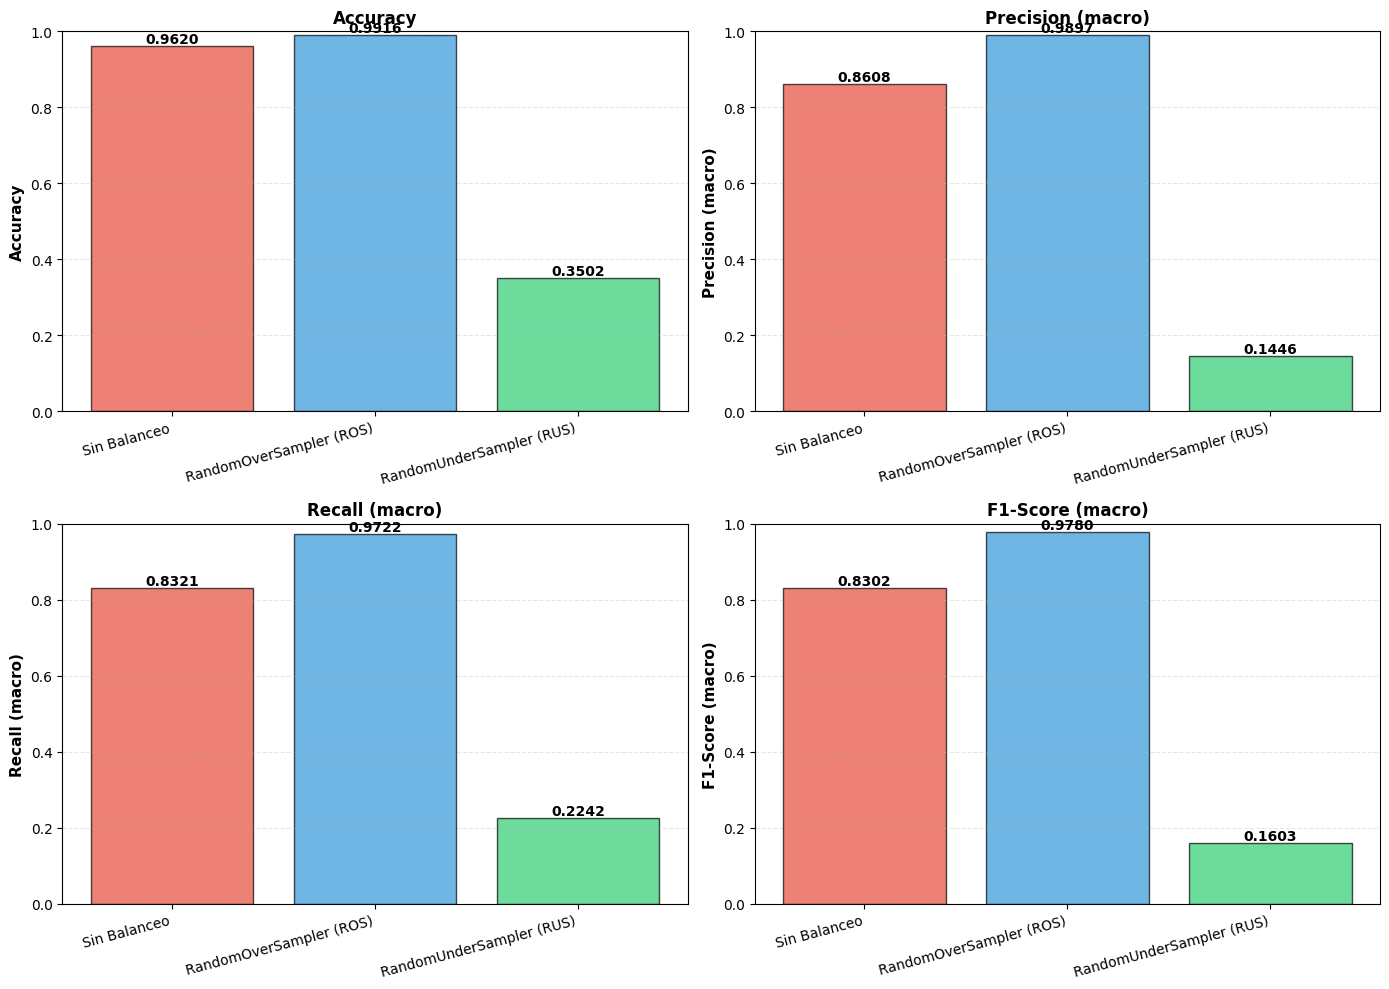

✓ Gráfico guardado en: models/comparacion_metricas_balanceo.png


In [28]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)']
colors = ['#e74c3c', '#3498db', '#2ecc71']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]
    x_pos = np.arange(len(comparacion_df))

    bars = ax.bar(x_pos, comparacion_df[metric], color=colors, alpha=0.7, edgecolor='black')

    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparacion_df['Estrategia'], rotation=15, ha='right')
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('models/comparacion_metricas_balanceo.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado en: models/comparacion_metricas_balanceo.png")

### 21.6 Curvas de aprendizaje (Loss y Accuracy)

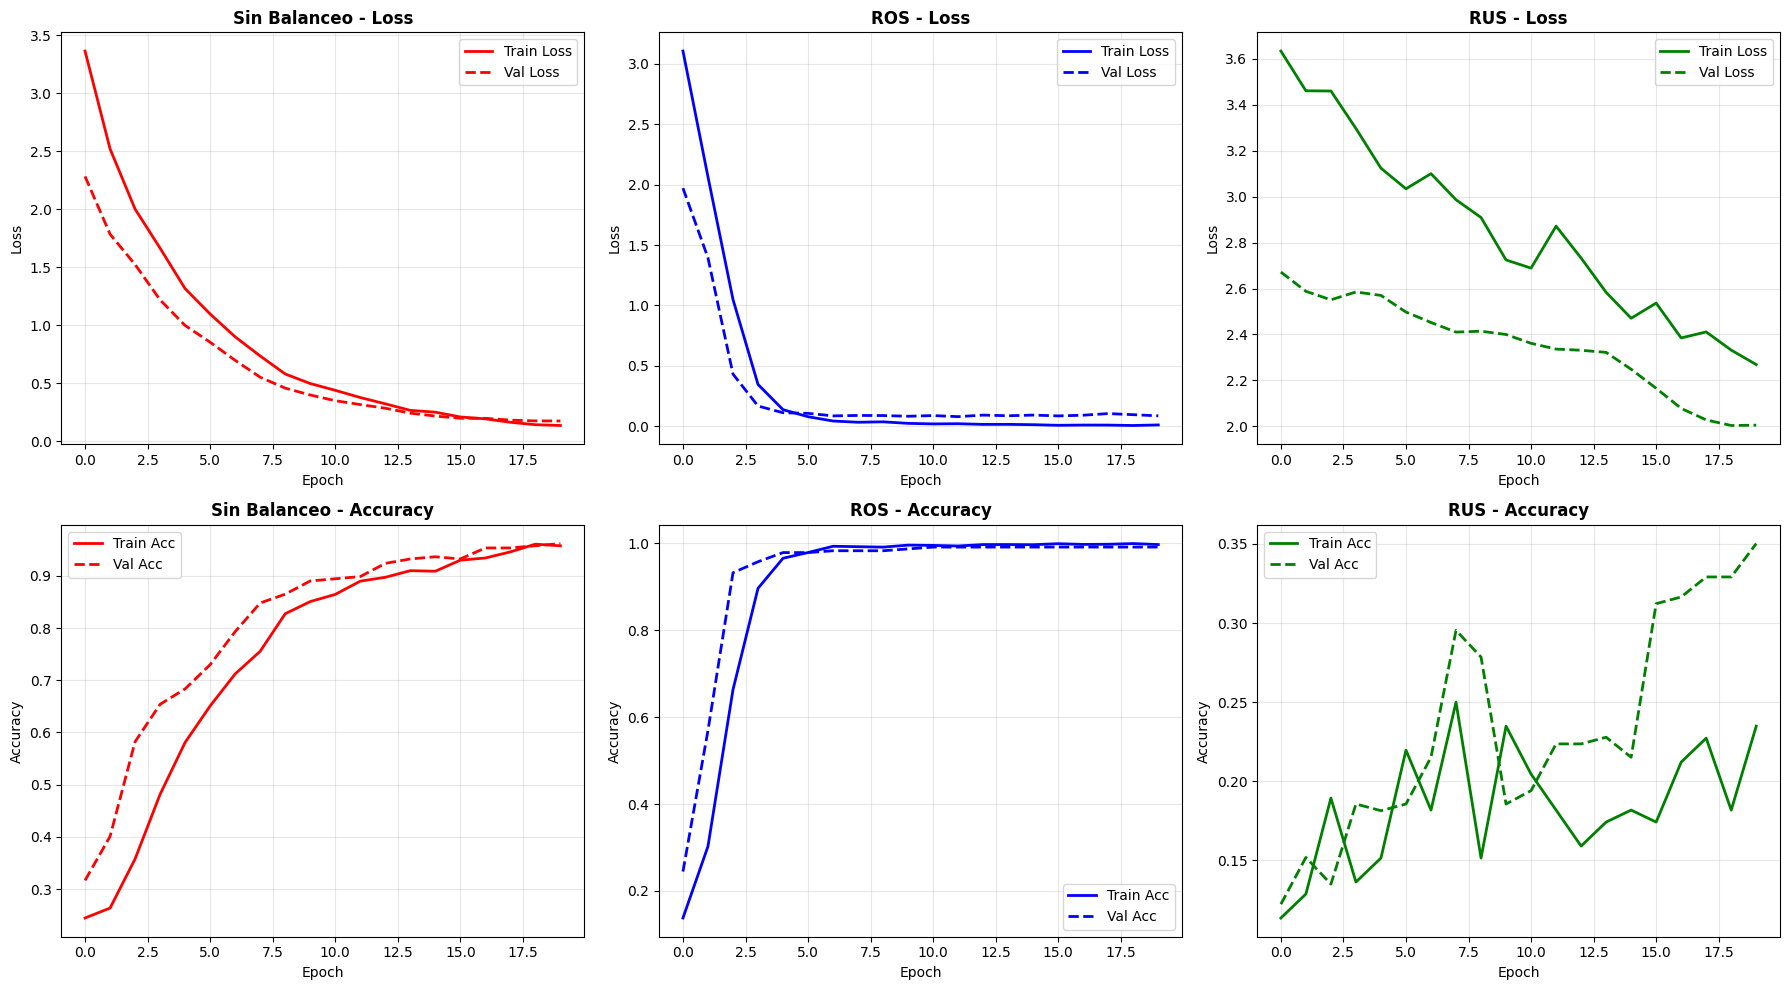

✓ Curvas guardadas en: models/curvas_aprendizaje_comparacion.png


In [29]:
# Curvas de aprendizaje
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss curves
histories = [
    (resultados_original['history'], 'Sin Balanceo', 'red'),
    (resultados_ros['history'], 'ROS', 'blue'),
    (resultados_rus['history'], 'RUS', 'green')
]

for idx, (history, nombre, color) in enumerate(histories):
    # Training Loss
    axes[0, idx].plot(history.history['loss'], label='Train Loss', color=color, linewidth=2)
    axes[0, idx].plot(history.history['val_loss'], label='Val Loss', color=color, linestyle='--', linewidth=2)
    axes[0, idx].set_title(f'{nombre} - Loss', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)

    # Training Accuracy
    axes[1, idx].plot(history.history['acc'], label='Train Acc', color=color, linewidth=2)
    axes[1, idx].plot(history.history['val_acc'], label='Val Acc', color=color, linestyle='--', linewidth=2)
    axes[1, idx].set_title(f'{nombre} - Accuracy', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Accuracy')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/curvas_aprendizaje_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Curvas guardadas en: models/curvas_aprendizaje_comparacion.png")

### 21.7 Comparación de matrices de confusión

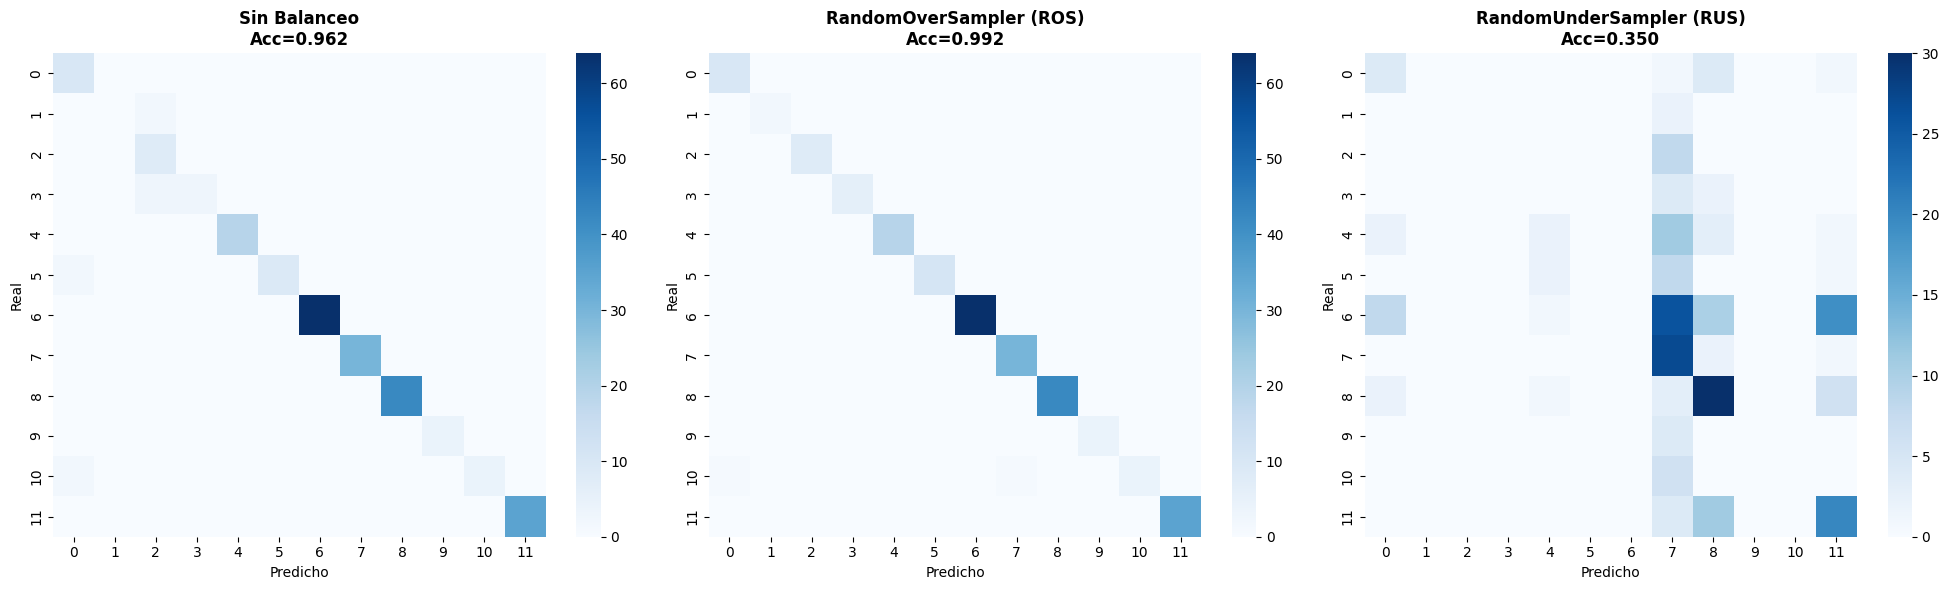

✓ Matrices guardadas en: models/confusion_matrices_comparacion.png


In [30]:
# Visualizar matrices de confusión lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

cms = [
    (resultados_original['cm'], 'Sin Balanceo'),
    (resultados_ros['cm'], 'RandomOverSampler (ROS)'),
    (resultados_rus['cm'], 'RandomUnderSampler (RUS)')
]

for idx, (cm_data, nombre) in enumerate(cms):
    sns.heatmap(cm_data, annot=False, cmap='Blues', cbar=True, fmt='d', ax=axes[idx])
    axes[idx].set_title(f'{nombre}\nAcc={comparacion_df.iloc[idx]["Accuracy"]:.3f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicho')
    axes[idx].set_ylabel('Real')

plt.tight_layout()
plt.savefig('models/confusion_matrices_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Matrices guardadas en: models/confusion_matrices_comparacion.png")

### Comparación de errores entre estrategias de balanceo

  Estrategia  Total_Errores  Total_Predicciones  Tasa_Error_%  Accuracy_%
Sin Balanceo              9                 237          3.80       96.20
         ROS              2                 237          0.84       99.16
         RUS            154                 237         64.98       35.02


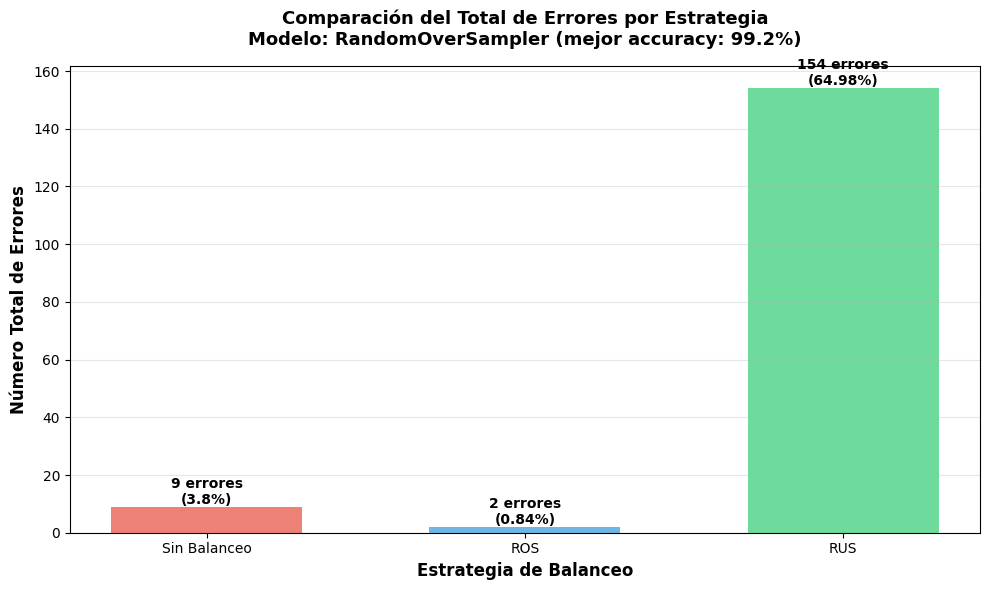


✓ Gráfico guardado en: models/comparacion_total_errores.png


In [31]:
# Comparación de errores entre las tres estrategias
print("### Comparación de errores entre estrategias de balanceo\n")

estrategias = [
    (resultados_original['cm'], 'Sin Balanceo'),
    (resultados_ros['cm'], 'ROS'),
    (resultados_rus['cm'], 'RUS')
]

comparacion_errores = []
for cm, nombre in estrategias:
    total_errores = np.sum(cm) - np.trace(cm)  # Total - diagonal
    total_predicciones = np.sum(cm)
    tasa_error = (total_errores / total_predicciones) * 100

    comparacion_errores.append({
        'Estrategia': nombre,
        'Total_Errores': int(total_errores),
        'Total_Predicciones': int(total_predicciones),
        'Tasa_Error_%': round(tasa_error, 2),
        'Accuracy_%': round((1 - tasa_error/100) * 100, 2)
    })

comparacion_df = pd.DataFrame(comparacion_errores)
print(comparacion_df.to_string(index=False))

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparacion_df))
width = 0.6

bars = ax.bar(x, comparacion_df['Total_Errores'], width,
              color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.7)

# Añadir valores sobre las barras
for i, (bar, row) in enumerate(zip(bars, comparacion_df.iterrows())):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f"{int(height)} errores\n({row[1]['Tasa_Error_%']}%)",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Estrategia de Balanceo', fontsize=12, fontweight='bold')
ax.set_ylabel('Número Total de Errores', fontsize=12, fontweight='bold')
ax.set_title('Comparación del Total de Errores por Estrategia\n' +
             f'Modelo: RandomOverSampler (mejor accuracy: {resultados_ros["metrics"]["accuracy"]:.1%})',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(comparacion_df['Estrategia'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('models/comparacion_total_errores.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado en: models/comparacion_total_errores.png")

### 21.8 Análisis por clase: Recall comparison


📊 Recall por clase (Top 15 clases más frecuentes):
 GRD  Sin Balanceo      ROS      RUS  Support
4416      1.000000 1.000000 0.000000       64
4418      1.000000 1.000000 0.714286       42
4421      1.000000 1.000000 0.571429       35
4417      1.000000 1.000000 0.900000       30
4411      1.000000 1.000000 0.105263       19
4415      0.818182 1.000000 0.000000       11
3413      1.000000 1.000000 0.400000       10
4102      1.000000 1.000000 0.000000        8
4120      0.500000 1.000000 0.000000        6
4420      0.666667 0.666667 0.000000        6
4419      1.000000 1.000000 0.000000        4
4101      0.000000 1.000000 0.000000        2


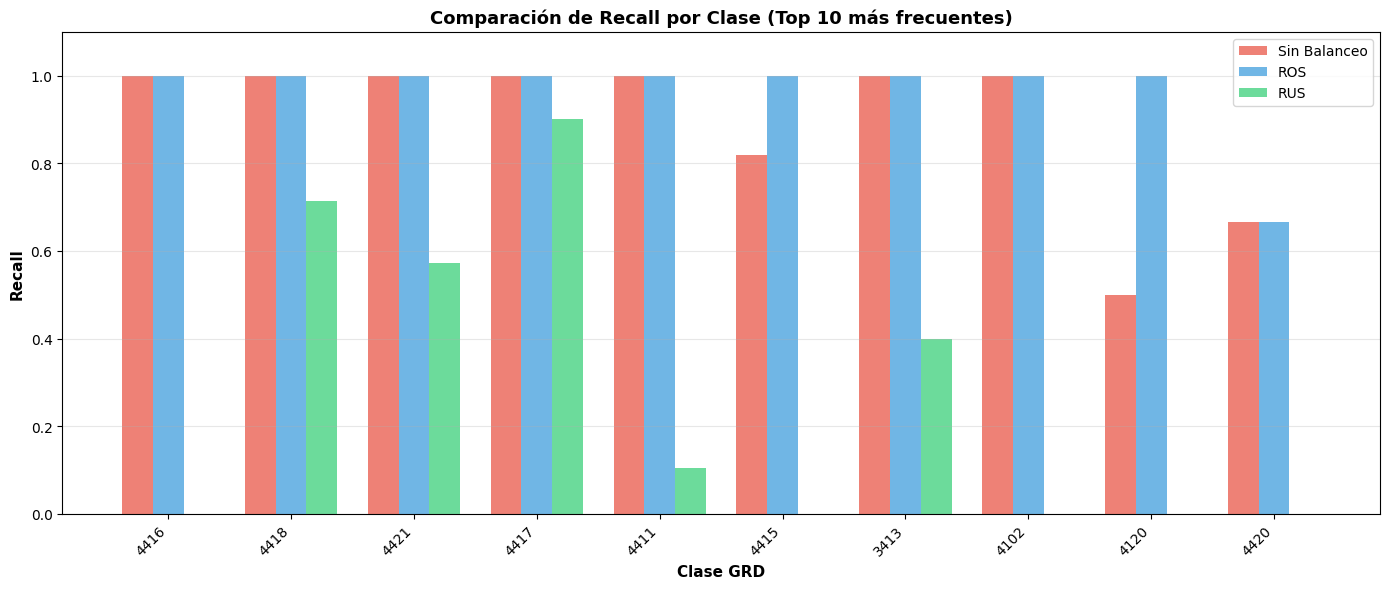


✓ Gráfico guardado en: models/recall_por_clase_comparacion.png


In [32]:
# Calcular recall por clase para cada estrategia
from sklearn.metrics import recall_score

y_true = np.argmax(y_test, axis=1)

recall_original = recall_score(y_true, resultados_original['predictions']['y_pred'],
                                average=None, zero_division=0)
recall_ros = recall_score(y_true, resultados_ros['predictions']['y_pred'],
                          average=None, zero_division=0)
recall_rus = recall_score(y_true, resultados_rus['predictions']['y_pred'],
                          average=None, zero_division=0)

# Crear DataFrame para comparación
recall_comparison = pd.DataFrame({
    'GRD': grd_labels,
    'Sin Balanceo': recall_original,
    'ROS': recall_ros,
    'RUS': recall_rus,
    'Support': pd.Series(y_true).value_counts().sort_index().values
})

# Ordenar por soporte (clases con más ejemplos primero)
recall_comparison = recall_comparison.sort_values('Support', ascending=False)

print("\n📊 Recall por clase (Top 15 clases más frecuentes):")
print(recall_comparison.head(15).to_string(index=False))

# Visualizar recall por clase para top 10
top_10_classes = recall_comparison.head(10)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(top_10_classes))
width = 0.25

bars1 = ax.bar(x - width, top_10_classes['Sin Balanceo'], width, label='Sin Balanceo',
               color='#e74c3c', alpha=0.7)
bars2 = ax.bar(x, top_10_classes['ROS'], width, label='ROS',
               color='#3498db', alpha=0.7)
bars3 = ax.bar(x + width, top_10_classes['RUS'], width, label='RUS',
               color='#2ecc71', alpha=0.7)

ax.set_xlabel('Clase GRD', fontsize=11, fontweight='bold')
ax.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax.set_title('Comparación de Recall por Clase (Top 10 más frecuentes)',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_classes['GRD'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('models/recall_por_clase_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en: models/recall_por_clase_comparacion.png")

### 23 Tabla comparativa de errores de clasificación

In [33]:
# Crear mapeo de índices a información GRD
# Importante: algunos GRD_final tienen múltiples códigos/descripciones
# Los agrupamos y concatenamos para mostrar todas las variantes
grd_info_grouped = encoded_df_filter_final.groupby('GRD_final').agg({
    'GRD_codigo': lambda x: x.dropna().drop_duplicates().tolist(),
    'GRD_descripcion': lambda x: x.dropna().drop_duplicates().tolist()
}).reset_index()

# Función para obtener información GRD
def get_grd_info(grd_idx):
    """
    Retorna código y descripción para un índice de GRD.
    Si hay múltiples valores, los concatena.
    """
    grd_code = grd_labels[grd_idx]
    row = grd_info_grouped[grd_info_grouped['GRD_final'] == grd_code]

    if len(row) == 0:
        return grd_code, grd_code, "Descripción no disponible"

    codigos = row.iloc[0]['GRD_codigo']
    descripciones = row.iloc[0]['GRD_descripcion']

    # Tomar primer código/descripción para simplicidad
    codigo = codigos[0] if isinstance(codigos, list) and len(codigos) > 0 else codigos
    descripcion = descripciones[0] if isinstance(descripciones, list) and len(descripciones) > 0 else descripciones

    return grd_code, codigo, descripcion

print(f"✓ Mapeo creado para {len(grd_labels)} clases GRD")
print(f"✓ Total de GRD únicos en mapping: {len(grd_info_grouped)}")

✓ Mapeo creado para 12 clases GRD
✓ Total de GRD únicos en mapping: 12


In [34]:
# Crear mapeo de GRD a precio FONASA 2016
grd_precios = encoded_df_filter_final.groupby('GRD_final')['Precio FONASA 2016'].first().to_dict()

print(f"✓ Precios disponibles para {len(grd_precios)} GRD")

# Crear tabla comparativa de errores para el modelo ROS (mejor rendimiento)
cm_ros = resultados_ros['cm']
errores_data = []

# Recorrer matriz de confusión y extraer errores (elementos fuera de la diagonal)
for i in range(len(grd_labels)):
    for j in range(len(grd_labels)):
        if i != j and cm_ros[i, j] > 0:  # Solo errores (no diagonal) con conteo > 0
            grd_real_idx, codigo_real, desc_real = get_grd_info(i)
            grd_pred_idx, codigo_pred, desc_pred = get_grd_info(j)

            # Obtener precios
            precio_real = grd_precios.get(grd_real_idx, 0)
            precio_pred = grd_precios.get(grd_pred_idx, 0)
            diferencia_precio = precio_real - precio_pred

            errores_data.append({
                'GRD_Real': grd_real_idx,
                'Codigo_Real': codigo_real,
                'Descripcion_Real': desc_real,
                'GRD_Predicho': grd_pred_idx,
                'Codigo_Predicho': codigo_pred,
                'Descripcion_Predicha': desc_pred,
                'Num_Errores': int(cm_ros[i, j]),
                'Precio_Real_FONASA': precio_real,
                'Precio_Pred_FONASA': precio_pred,
                'Diferencia_Precio': diferencia_precio,
                'Perdida_Total': diferencia_precio * cm_ros[i, j]
            })

# Crear DataFrame y ordenar por pérdida total absoluta
errores_df = pd.DataFrame(errores_data)
errores_df['Perdida_Abs'] = errores_df['Perdida_Total'].abs()
errores_df = errores_df.sort_values('Perdida_Abs', ascending=False)

# Guardar tabla completa
errores_df.to_csv('models/tabla_errores_clasificacion.csv', index=False)

print(f"\n✓ Total de pares con errores: {len(errores_df)}")
print(f"✓ Total de errores: {errores_df['Num_Errores'].sum()}")
print(f"\n💰 Impacto económico:")
print(f"  Pérdida total: ${errores_df['Perdida_Total'].sum():,.0f}")
print(f"  Pérdida promedio por error: ${errores_df['Perdida_Total'].mean():,.0f}")
print(f"\n📊 Top 15 errores con mayor impacto económico:\n")
print(errores_df[['GRD_Real', 'GRD_Predicho', 'Num_Errores', 'Precio_Real_FONASA',
                   'Precio_Pred_FONASA', 'Diferencia_Precio', 'Perdida_Total']].head(15).to_string(index=False))
print(f"\n✓ Tabla completa guardada en: models/tabla_errores_clasificacion.csv")

✓ Precios disponibles para 12 GRD

✓ Total de pares con errores: 2
✓ Total de errores: 2

💰 Impacto económico:
  Pérdida total: $-146,700
  Pérdida promedio por error: $-73,350

📊 Top 15 errores con mayor impacto económico:

 GRD_Real  GRD_Predicho  Num_Errores  Precio_Real_FONASA  Precio_Pred_FONASA  Diferencia_Precio  Perdida_Total
     4420          4417            1            795900.0           1282650.0          -486750.0      -486750.0
     4420          3413            1            795900.0            455850.0           340050.0       340050.0

✓ Tabla completa guardada en: models/tabla_errores_clasificacion.csv


In [35]:
errores_df

,GRD_Real,Codigo_Real,Descripcion_Real,GRD_Predicho,Codigo_Predicho,Descripcion_Predicha,Num_Errores,Precio_Real_FONASA,Precio_Pred_FONASA,Diferencia_Precio,Perdida_Total,Perdida_Abs
1,4420,44201,MH DERRAME PLEURAL Y NEUMOTÓRAX,4417,44173,MH ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA W/MCC,1,795900.0,1282650.0,-486750.0,-486750.0,486750.0
0,4420,44201,MH DERRAME PLEURAL Y NEUMOTÓRAX,3413,34131,"MH EPIGLOTITIS, OTITIS MEDIA, INFECCIONES TRAC...",1,795900.0,455850.0,340050.0,340050.0,340050.0


### 24 Conclusiones: ROS vs RUS

**Análisis de resultados:**

1. **Accuracy General:**
   - Métrica global que puede ser engañosa en datasets desbalanceados
   - Favorece clases mayoritarias en modelo sin balanceo

2. **Precision, Recall y F1 (macro):**
   - Promedian métricas de todas las clases por igual
   - Mejor indicador de rendimiento balanceado entre clases

3. **Trade-offs observados:**

   **RandomOverSampler (ROS):**
   - ✅ Mantiene toda la información original
   - ✅ Mejor para clases minoritarias
   - ⚠️ Mayor tiempo de entrenamiento (más datos)
   - ⚠️ Riesgo de overfitting (duplica ejemplos)
   
   **RandomUnderSampler (RUS):**
   - ✅ Entrenamiento más rápido (menos datos)
   - ✅ Menor riesgo de overfitting
   - ⚠️ Pierde información de clases mayoritarias
   - ⚠️ Puede subajustar en clases con pocos ejemplos
   
   **Sin Balanceo (Baseline):**
   - ✅ Representa distribución real de datos
   - ✅ No introduce sesgo artificial
   - ⚠️ Sesgo hacia clases mayoritarias
   - ⚠️ Pobre recall en clases minoritarias

4. **Recomendación:**
   - Si **tiempo** es limitado → RUS
   - Si **recall en minoritarias** es crítico → ROS
   - Si distribución real importa → Sin balanceo + class_weight
   - En general: **ROS tiende a mejor F1 macro** para problemas multiclase desbalanceados